In [42]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from gluonts.torch import DeepAREstimator
from gluonts.evaluation import Evaluator
from gluonts.torch.model.deepar import DeepARLightningModule
from pytorch_lightning import Trainer
from gluonts.dataset.common import ListDataset
from gluonts.model.predictor import Predictor

In [3]:
## Read the CSV file
#file_path_1 = 'C:\Theo\School\ESIEE\Annee\E5\TimeSeries\Projet DeepAR\Dataset\ETT-small\ETTh1.csv'
#file_path_2 = 'C:\Theo\School\ESIEE\Annee\E5\TimeSeries\Projet DeepAR\Dataset\ETT-small\ETTh2.csv'
#file_path_3 = 'C:\Theo\School\ESIEE\Annee\E5\TimeSeries\Projet DeepAR\Dataset\ETT-small\ETTm1.csv'
#file_path_4 = 'C:\Theo\School\ESIEE\Annee\E5\TimeSeries\Projet DeepAR\Dataset\ETT-small\ETTm2.csv'
#
#df_1 = pd.read_csv(file_path_1)
#df_2 = pd.read_csv(file_path_2)
#df_3 = pd.read_csv(file_path_3)
#df_4 = pd.read_csv(file_path_4)

In [4]:
#print(df_1.shape)
#print(df_2.shape)
#print(df_3.shape)
#print(df_4.shape)

In [5]:
#display(df_4)

In [2]:
file_path_weather = 'C:\Theo\School\ESIEE\Annee\E5\TimeSeries\Projet DeepAR\Dataset\weather\weather.csv'

df_weather = pd.read_csv(file_path_weather)

In [3]:
display(df_weather)

,date,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),...,wv (m/s),max. wv (m/s),wd (deg),rain (mm),raining (s),SWDR (W/m�),PAR (�mol/m�/s),max. PAR (�mol/m�/s),Tlog (degC),OT
0,2020-01-01 00:10:00,1008.89,0.71,273.18,-1.33,86.1,6.43,5.54,0.89,3.42,...,1.02,1.60,224.3,0.0,0.0,0.0,0.0,0.0,11.45,428.1
1,2020-01-01 00:20:00,1008.76,0.75,273.22,-1.44,85.2,6.45,5.49,0.95,3.39,...,0.43,0.84,206.8,0.0,0.0,0.0,0.0,0.0,11.51,428.0
2,2020-01-01 00:30:00,1008.66,0.73,273.21,-1.48,85.1,6.44,5.48,0.96,3.39,...,0.61,1.48,197.1,0.0,0.0,0.0,0.0,0.0,11.60,427.6
3,2020-01-01 00:40:00,1008.64,0.37,272.86,-1.64,86.3,6.27,5.41,0.86,3.35,...,1.11,1.48,206.4,0.0,0.0,0.0,0.0,0.0,11.70,430.0
4,2020-01-01 00:50:00,1008.61,0.33,272.82,-1.50,87.4,6.26,5.47,0.79,3.38,...,0.49,1.40,209.6,0.0,0.0,0.0,0.0,0.0,11.81,432.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52691,2020-12-31 23:20:00,978.32,2.28,277.16,-0.80,80.0,7.20,5.76,1.44,3.67,...,0.73,1.40,180.6,0.0,0.0,0.0,0.0,0.0,13.40,433.0
52692,2020-12-31 23:30:00,978.30,2.13,277.01,-0.43,83.1,7.12,5.92,1.20,3.77,...,0.43,0.82,174.0,0.0,0.0,0.0,0.0,0.0,13.42,439.6
52693,2020-12-31 23:40:00,978.26,1.99,276.88,-0.71,82.2,7.05,5.80,1.26,3.69,...,0.38,0.76,248.9,0.0,0.0,0.0,0.0,0.0,13.45,435.2
52694,2020-12-31 23:50:00,978.26,2.07,276.95,-0.77,81.4,7.09,5.77,1.32,3.68,...,0.57,1.07,196.6,0.0,0.0,0.0,0.0,0.0,13.47,433.9


In [8]:
## Convert 'date' column to datetime
#df_electricity['date'] = pd.to_datetime(df_electricity['date'])
#
## Select all columns except 'date' to plot
#columns_to_plot = df_electricity.columns.drop('date')
#
## Plot all columns against the date
#df_electricity.plot(x='date', y=columns_to_plot, figsize=(10,6), legend=False)
#
## Customize the plot
#plt.title('All Data over Time')
#plt.xlabel('Date')
#plt.ylabel('Values')
#plt.grid(True)
#plt.tight_layout()
#
## Show the plot
#plt.show()

In [4]:
# Conversion de la colonne 'date' en format datetime
df_weather['date'] = pd.to_datetime(df_weather['date'], format='%Y-%m-%d %H:%M:%S')

In [5]:
# Création d'une colonne 'season' basée sur le mois
def get_season(month):
    if month in [12, 1, 2]:
        return 0
    elif month in [3, 4, 5]:
        return 1
    elif month in [6, 7, 8]:
        return 2
    else:
        return 3

In [6]:
# Création d'une colonne 'wind_chill'
def calculate_wind_chill(temp, wind_speed):
    if temp <= 10 and wind_speed > 4.8:
        return 13.12 + 0.6215 * temp - 11.37 * (wind_speed ** 0.16) + 0.3965 * temp * (wind_speed ** 0.16)
    else:
        return temp

In [7]:
# Création de caractéristiques temporelles à partir de la colonne 'date'
df_weather['month'] = df_weather['date'].dt.month
df_weather['day_of_week'] = df_weather['date'].dt.dayofweek
df_weather['hour'] = df_weather['date'].dt.hour
df_weather['season'] = df_weather['month'].apply(get_season)
df_weather['week_of_year'] = df_weather['date'].dt.isocalendar().week

In [8]:
# Amplitude journalière de la température (différence entre max et min température sur une journée)
df_weather['temp_daily_amplitude'] = df_weather['T (degC)'].rolling(window=24).max() - df_weather['T (degC)'].rolling(window=24).min()

# Différence de température d'une heure à l'autre
df_weather['temp_delta'] = df_weather['T (degC)'].diff(periods=1)

# Lag Features (température des dernières 1, 3, et 6 heures)
df_weather['temp_lag_1h'] = df_weather['T (degC)'].shift(1)
df_weather['temp_lag_3h'] = df_weather['T (degC)'].shift(3)
df_weather['temp_lag_6h'] = df_weather['T (degC)'].shift(6)

# Interaction entre VPmax et Tdew
df_weather['VPmax_Tdew_interaction'] = df_weather['VPmax (mbar)'] * df_weather['Tdew (degC)']

# Indice thermique (approximation simple avec température et humidité)
df_weather['heat_index'] = 0.5 * (df_weather['T (degC)'] + 61.0 + ((df_weather['T (degC)'] - 68.0) * 1.2) + (df_weather['rh (%)'] * 0.094))

# Indice de confort (Wind Chill)
df_weather['wind_chill'] = df_weather.apply(lambda row: calculate_wind_chill(row['T (degC)'], row['wv (m/s)'] * 3.6), axis=1)

In [9]:
# Définir une fenêtre de 3 heures (ou 3 périodes dans notre cas)
window_size = 3

# Créer des features rolling mean et rolling std pour les colonnes pertinentes
df_weather['Tdew_rolling_mean'] = df_weather['Tdew (degC)'].rolling(window=window_size).mean()
df_weather['Tdew_rolling_std'] = df_weather['Tdew (degC)'].rolling(window=window_size).std()

df_weather['VPmax_rolling_mean'] = df_weather['VPmax (mbar)'].rolling(window=window_size).mean()
df_weather['VPmax_rolling_std'] = df_weather['VPmax (mbar)'].rolling(window=window_size).std()

df_weather['rho_rolling_mean'] = df_weather['rho (g/m**3)'].rolling(window=window_size).mean()
df_weather['rho_rolling_std'] = df_weather['rho (g/m**3)'].rolling(window=window_size).std()


In [10]:
# Supprimer les lignes avec des NaN dans les colonnes avec des valeurs manquantes
df_weather = df_weather.dropna()

In [11]:
# Vérifier les valeurs manquantes dans le dataset
missing_values = df_weather.isnull().sum()

# Afficher les résultats
missing_values

date                      0
p (mbar)                  0
T (degC)                  0
Tpot (K)                  0
Tdew (degC)               0
rh (%)                    0
VPmax (mbar)              0
VPact (mbar)              0
VPdef (mbar)              0
sh (g/kg)                 0
H2OC (mmol/mol)           0
rho (g/m**3)              0
wv (m/s)                  0
max. wv (m/s)             0
wd (deg)                  0
rain (mm)                 0
raining (s)               0
SWDR (W/m�)               0
PAR (�mol/m�/s)           0
max. PAR (�mol/m�/s)      0
Tlog (degC)               0
OT                        0
month                     0
day_of_week               0
hour                      0
season                    0
week_of_year              0
temp_daily_amplitude      0
temp_delta                0
temp_lag_1h               0
temp_lag_3h               0
temp_lag_6h               0
VPmax_Tdew_interaction    0
heat_index                0
wind_chill                0
Tdew_rolling_mean   

In [12]:
# Afficher les premières lignes pour vérifier les nouvelles colonnes
df_weather.columns

Index(['date', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)',
       'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)', 'rain (mm)', 'raining (s)', 'SWDR (W/m�)',
       'PAR (�mol/m�/s)', 'max. PAR (�mol/m�/s)', 'Tlog (degC)', 'OT', 'month',
       'day_of_week', 'hour', 'season', 'week_of_year', 'temp_daily_amplitude',
       'temp_delta', 'temp_lag_1h', 'temp_lag_3h', 'temp_lag_6h',
       'VPmax_Tdew_interaction', 'heat_index', 'wind_chill',
       'Tdew_rolling_mean', 'Tdew_rolling_std', 'VPmax_rolling_mean',
       'VPmax_rolling_std', 'rho_rolling_mean', 'rho_rolling_std'],
      dtype='object')

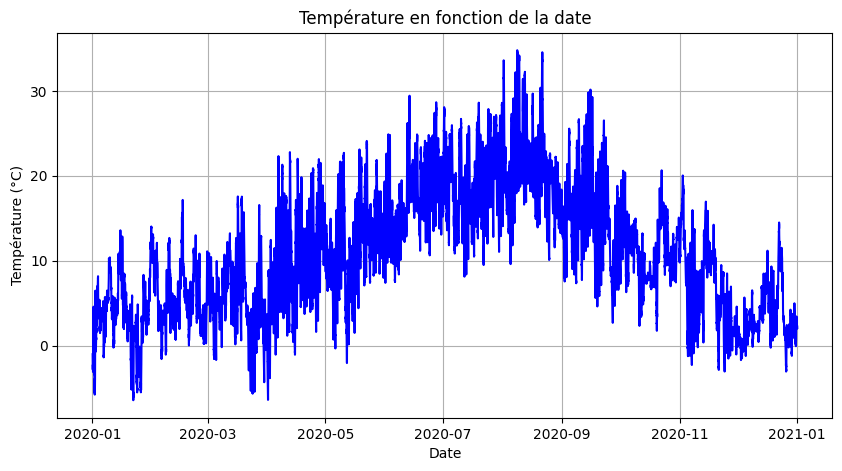

In [13]:
# Graphique 1: Température en fonction de la colonne date
plt.figure(figsize=(10, 5))
plt.plot(df_weather['date'], df_weather['T (degC)'], label='Température (°C)', color='b')
plt.xlabel('Date')
plt.ylabel('Température (°C)')
plt.title('Température en fonction de la date')
plt.grid(True)
plt.show()


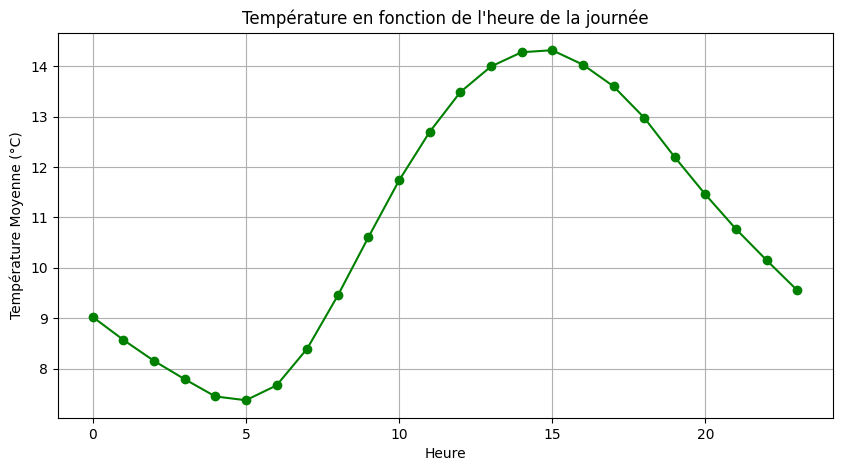

In [14]:
# Graphique 2: Température en fonction de la colonne hour
plt.figure(figsize=(10, 5))
hourly_temp = df_weather.groupby('hour')['T (degC)'].mean()
plt.plot(hourly_temp.index, hourly_temp.values, marker='o', linestyle='-', color='g')
plt.xlabel('Heure')
plt.ylabel('Température Moyenne (°C)')
plt.title('Température en fonction de l\'heure de la journée')
plt.grid(True)
plt.show()

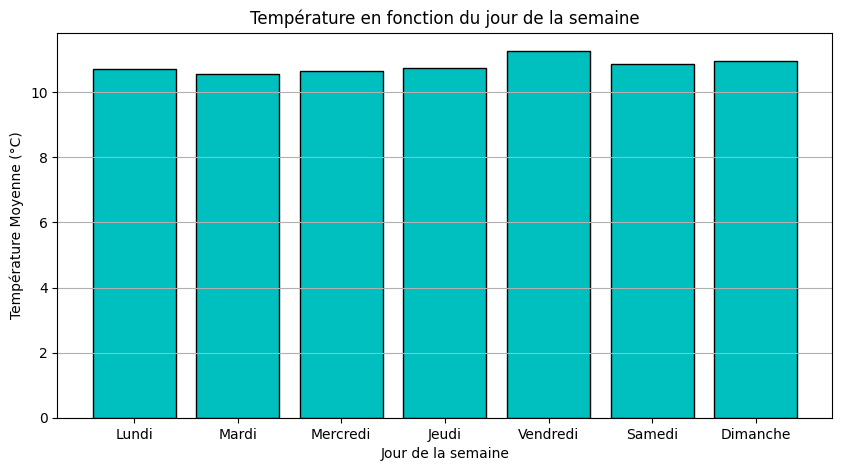

In [15]:
# Graphique 3: Température en fonction du jour de la semaine
plt.figure(figsize=(10, 5))
weekly_temp = df_weather.groupby('day_of_week')['T (degC)'].mean()
plt.bar(weekly_temp.index, weekly_temp.values, color='c', edgecolor='black')
plt.xlabel('Jour de la semaine')
plt.ylabel('Température Moyenne (°C)')
plt.title('Température en fonction du jour de la semaine')
plt.xticks(range(0, 7), ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche'])
plt.grid(axis='y')
plt.show()

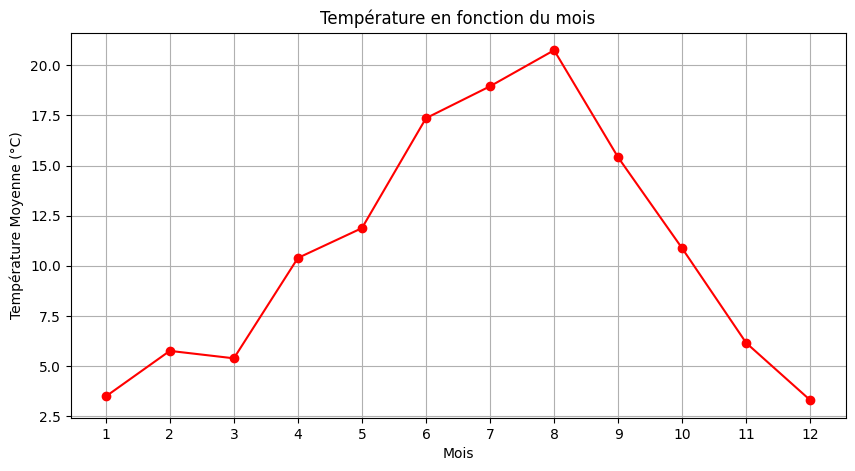

In [16]:
# Graphique 4: Température en fonction du mois
plt.figure(figsize=(10, 5))
monthly_temp = df_weather.groupby('month')['T (degC)'].mean()
plt.plot(monthly_temp.index, monthly_temp.values, marker='o', linestyle='-', color='r')
plt.xlabel('Mois')
plt.ylabel('Température Moyenne (°C)')
plt.title('Température en fonction du mois')
plt.grid(True)
plt.xticks(range(1, 13))
plt.show()

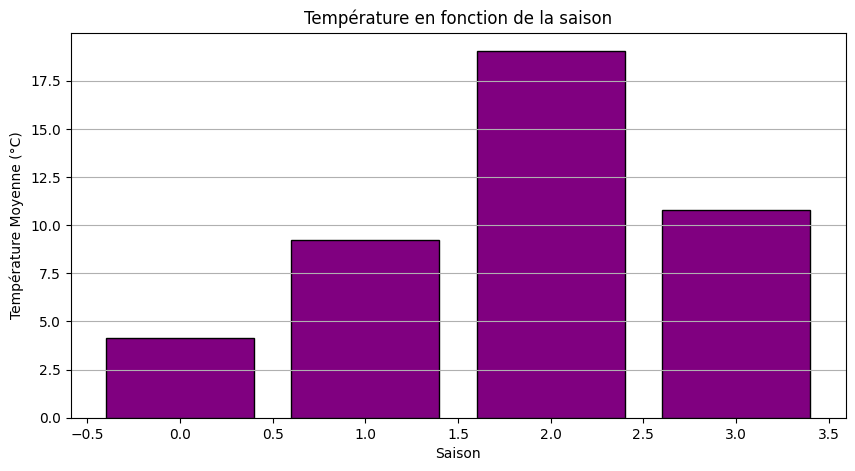

In [17]:
# Graphique 5: Température en fonction de la saison
plt.figure(figsize=(10, 5))
seasonal_temp = df_weather.groupby('season')['T (degC)'].mean()
plt.bar(seasonal_temp.index, seasonal_temp.values, color='purple', edgecolor='black')
plt.xlabel('Saison')
plt.ylabel('Température Moyenne (°C)')
plt.title('Température en fonction de la saison')
plt.grid(axis='y')
plt.show()

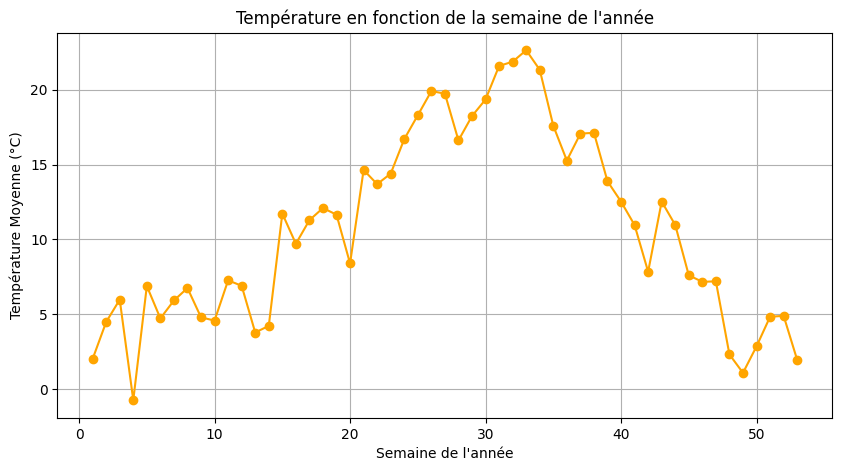

In [18]:
# Graphique 6: Température en fonction de la semaine de l'année
plt.figure(figsize=(10, 5))
weekly_year_temp = df_weather.groupby('week_of_year')['T (degC)'].mean()
plt.plot(weekly_year_temp.index, weekly_year_temp.values, marker='o', linestyle='-', color='orange')
plt.xlabel('Semaine de l\'année')
plt.ylabel('Température Moyenne (°C)')
plt.title('Température en fonction de la semaine de l\'année')
plt.grid(True)
plt.show()

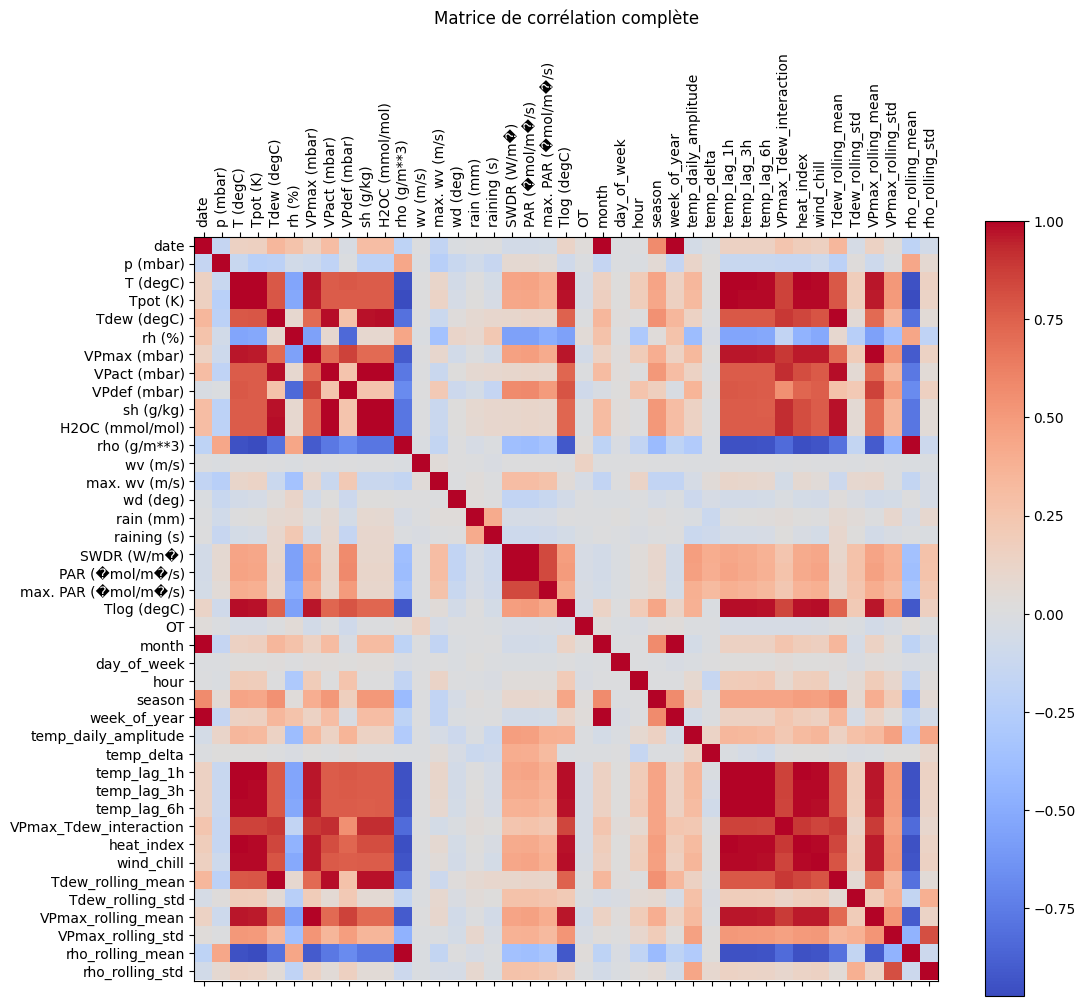

                            date  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  \
date                    1.000000 -0.149699  0.147997  0.159394     0.339649   
p (mbar)               -0.149699  1.000000 -0.126206 -0.222360    -0.206475   
T (degC)                0.147997 -0.126206  1.000000  0.995229     0.782584   
Tpot (K)                0.159394 -0.222360  0.995229  1.000000     0.789328   
Tdew (degC)             0.339649 -0.206475  0.782584  0.789328     1.000000   
rh (%)                  0.264094 -0.069163 -0.540595 -0.524682     0.087672   
VPmax (mbar)            0.141724 -0.098058  0.967905  0.961040     0.712501   
VPact (mbar)            0.304256 -0.183036  0.762723  0.767648     0.977404   
VPdef (mbar)           -0.025714 -0.002165  0.779601  0.766565     0.271795   
sh (g/kg)               0.304437 -0.200230  0.761407  0.768060     0.976867   
H2OC (mmol/mol)         0.304839 -0.200448  0.761791  0.768458     0.977246   
rho (g/m**3)           -0.191705  0.436455 -0.946503

In [19]:
# Calcul de la matrice de corrélation avec toutes les colonnes disponibles
correlation_matrix_full = df_weather.corr()

# Afficher la matrice de corrélation complète
plt.figure(figsize=(12, 10))
plt.matshow(correlation_matrix_full, cmap='coolwarm', fignum=1)
plt.colorbar()
plt.xticks(range(correlation_matrix_full.shape[1]), correlation_matrix_full.columns, rotation=90)
plt.yticks(range(correlation_matrix_full.shape[1]), correlation_matrix_full.columns)
plt.title('Matrice de corrélation complète', pad=20)
plt.show()

# Afficher la matrice de corrélation complète en version tableau
print(correlation_matrix_full)


# Caractéristiques avec une forte corrélation avec la température :

Tpot (K) : Très forte corrélation (0.995), mais potentiellement redondante avec la température elle-même. Cela pourrait être exclu pour éviter la redondance.

Tdew (degC) : Corrélation élevée (0.783), ce qui indique que la température de rosée a une influence importante sur la température.

VPmax (mbar) : Corrélation forte (0.968), la pression de vapeur maximale est pertinente.

Tlog (degC) : Très forte corrélation (0.982), mais potentiellement redondante avec la température. À évaluer si nécessaire.

VPact (mbar) : Moyenne à forte corrélation (~0.76).

rho (g/m³) : Corrélation négative forte (~-0.95), ce qui en fait une caractéristique intéressante pour la prédiction.

temp_lag_1h : Très forte corrélation (0.999), donc la température avec un décalage d'une heure est très pertinente.

temp_lag_3h et temp_lag_6h : Corrélations élevées (0.996 et 0.989), donc les décalages à 3 et 6 heures sont également utiles.

VPmax_Tdew_interaction : Corrélation forte (0.856), l'interaction entre la pression de vapeur maximale et la température de rosée est pertinente.

heat_index : Très forte corrélation (0.995), indiquant que l'indice thermique est également une bonne mesure.

Tdew_rolling_mean : Corrélation modérée (0.782), la moyenne mobile de la température de rosée est également utile.

VPmax_rolling_mean : Forte corrélation positive (0.968), la moyenne mobile de la pression de vapeur maximale est un bon prédicteur.

rho_rolling_mean : Forte corrélation négative (-0.946), la moyenne mobile de la densité de l'air influence la température de manière inverse.

# Variables temporelles :

month : Corrélation modérée, pertinente pour capturer les variations saisonnières.

hour : Corrélation modérée avec la température, utile pour capturer les variations diurnes.

season et week_of_year : Peuvent être incluses pour aider à capturer les tendances saisonnières.

# Sélection finale pour le modèle DeepAR :

Tdew (degC)

VPmax (mbar)

rho (g/m³)

temp_lag_1h

temp_lag_3h

temp_lag_6h

VPmax_Tdew_interaction

heat_index

Tdew_rolling_mean

VPmax_rolling_mean

rho_rolling_mean

month

hour

week_of_year


In [20]:
# Inclure toutes les features sélectionnées dans la nouvelle dataframe df_final
all_selected_features = ['date', 'month', 'hour', 'week_of_year','Tdew (degC)',
                         'VPmax (mbar)', 'rho (g/m**3)', 'temp_lag_1h',
                         'temp_lag_3h', 'temp_lag_6h', 'VPmax_Tdew_interaction', 
                         'heat_index', 'Tdew_rolling_mean', 'VPmax_rolling_mean',
                         'rho_rolling_mean', 'T (degC)']

# Créer la nouvelle dataframe df_final avec toutes les caractéristiques sélectionnées
df_final = df_weather[all_selected_features].copy()

# Appliquer la standardisation uniquement aux colonnes pertinentes
features_to_standardize = ['Tdew (degC)', 'VPmax (mbar)', 'rho (g/m**3)', 
                           'temp_lag_1h', 'temp_lag_3h', 'temp_lag_6h', 
                           'VPmax_Tdew_interaction', 'heat_index', 
                           'Tdew_rolling_mean', 'VPmax_rolling_mean',
                           'rho_rolling_mean']

# Recréer le standardiseur
scaler = StandardScaler()

# Standardiser les colonnes pertinentes
df_final[features_to_standardize] = scaler.fit_transform(df_final[features_to_standardize])

In [21]:
# Vérifier les dates minimales et maximales dans les données pour ajuster le split
min_date = df_final['date'].min()
max_date = df_final['date'].max()

print(f"Dates disponibles : De {min_date} à {max_date}")

Dates disponibles : De 2020-01-01 04:00:00 à 2021-01-01 00:00:00


In [22]:
df_final.head()

,date,month,hour,week_of_year,Tdew (degC),VPmax (mbar),rho (g/m**3),temp_lag_1h,temp_lag_3h,temp_lag_6h,VPmax_Tdew_interaction,heat_index,Tdew_rolling_mean,VPmax_rolling_mean,rho_rolling_mean,T (degC)
23,2020-01-01 04:00:00,1,4,1,-1.296531,-1.155672,2.114450,-1.565978,-1.573967,-1.456057,-0.900272,-1.566775,-1.280672,-1.150923,2.103166,-1.02
24,2020-01-01 04:10:00,1,4,1,-1.306605,-1.163533,2.123514,-1.586067,-1.564592,-1.477484,-0.901710,-1.582170,-1.291868,-1.156166,2.112873,-1.15
25,2020-01-01 04:20:00,1,4,1,-1.286457,-1.159603,2.116372,-1.603477,-1.565931,-1.552479,-0.897310,-1.570434,-1.296907,-1.160098,2.118551,-1.08
26,2020-01-01 04:30:00,1,4,1,-1.400626,-1.187117,2.186690,-1.594102,-1.586020,-1.573906,-0.920703,-1.649973,-1.331615,-1.170584,2.142637,-1.59
27,2020-01-01 04:40:00,1,4,1,-1.398947,-1.198908,2.221849,-1.662404,-1.603430,-1.564532,-0.918399,-1.672879,-1.362405,-1.182381,2.175422,-1.82


In [23]:
# Supprimer les doublons dans la colonne 'date'
df_final = df_final.drop_duplicates(subset='date')

# Vérifier si les dates sont régulièrement espacées
df_final = df_final.set_index('date').asfreq('H').reset_index()

# Sélectionner uniquement les colonnes numériques pour l'interpolation
numeric_cols = df_final.select_dtypes(include=['float64', 'int64']).columns

# Appliquer l'interpolation uniquement sur les colonnes numériques
df_final[numeric_cols] = df_final[numeric_cols].interpolate(method='linear')

In [24]:
# Vérifier s'il y a encore des valeurs manquantes
print(df_final.isnull().sum())

date                      0
month                     0
hour                      0
week_of_year              2
Tdew (degC)               0
VPmax (mbar)              0
rho (g/m**3)              0
temp_lag_1h               0
temp_lag_3h               0
temp_lag_6h               0
VPmax_Tdew_interaction    0
heat_index                0
Tdew_rolling_mean         0
VPmax_rolling_mean        0
rho_rolling_mean          0
T (degC)                  0
dtype: int64


In [25]:
# Vérifier les colonnes présentes dans la dataframe
print(df_final.columns)

Index(['date', 'month', 'hour', 'week_of_year', 'Tdew (degC)', 'VPmax (mbar)',
       'rho (g/m**3)', 'temp_lag_1h', 'temp_lag_3h', 'temp_lag_6h',
       'VPmax_Tdew_interaction', 'heat_index', 'Tdew_rolling_mean',
       'VPmax_rolling_mean', 'rho_rolling_mean', 'T (degC)'],
      dtype='object')


In [26]:
# Définir la variable cible et les autres colonnes de features
target_column = 'T (degC)'
feature_columns = ['Tdew (degC)', 'VPmax (mbar)', 'rho (g/m**3)', 'month', 'hour', 'week_of_year',
                   'temp_lag_1h', 'temp_lag_3h', 'temp_lag_6h', 'VPmax_Tdew_interaction', 'heat_index']

In [27]:
# Split des données : entraînement jusqu'à octobre 2020 et validation d'octobre 2020 à janvier 2021
train = df_final.loc[df_final['date'] < '2020-10-01']
valid = df_final.loc[(df_final['date'] >= '2020-10-01') & (df_final['date'] < '2021-01-01')]

In [28]:
# Ajouter un item_id factice pour chaque ligne (nécessaire pour GluonTS)
train['item_id'] = 0
valid['item_id'] = 0

C:\Users\Usuario\AppData\Local\Temp\ipykernel_25160\2931310786.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['item_id'] = 0
C:\Users\Usuario\AppData\Local\Temp\ipykernel_25160\2931310786.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['item_id'] = 0


In [29]:
# Créer les datasets GluonTS avec ListDataset
train_ds = ListDataset(
    [{"start": train['date'].iloc[0], "target": train[target_column].values}],
    freq="H"
)

valid_ds = ListDataset(
    [{"start": valid['date'].iloc[0], "target": valid[target_column].values}],
    freq="H"
)

In [53]:
# Configurer le modèle DeepAR avec PyTorch
estimator = DeepAREstimator(
    freq="H",  # Fréquence horaire
    prediction_length=24,  # Longueur de l'horizon de prédiction (24 heures)
    trainer_kwargs={
        "max_epochs": 6,  # Nombre d'époques
        "limit_train_batches": 100  # Limiter le nombre de batches par époque
    }
)

In [54]:
# Entraîner le modèle sur les données d'entraînement
predictor = estimator.train(train_ds)

# Faire des prédictions sur le dataset de test
predictions = list(predictor.predict(valid_ds))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name  | Type        | Params | In sizes                                                      | Out sizes   
---------------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 27.6 K | [[1, 1], [1, 1], [1, 744, 5], [1, 744], [1, 744], [1, 24, 5]] | [1, 100, 24]
---------------------------------------------------------------------------------------------------------------------
27.6 K    Trainable params
0         Non-trainable params
27.6 K    Total params
0.111     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 50: 'train_loss' reached 3.11877 (best 3.11877), saving model to 'c:\\Theo\\School\\ESIEE\\Annee\\E5\\TimeSeries\\Projet DeepAR\\lightning_logs\\version_7\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 2.52879 (best 2.52879), saving model to 'c:\\Theo\\School\\ESIEE\\Annee\\E5\\TimeSeries\\Projet DeepAR\\lightning_logs\\version_7\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 2.12310 (best 2.12310), saving model to 'c:\\Theo\\School\\ESIEE\\Annee\\E5\\TimeSeries\\Projet DeepAR\\lightning_logs\\version_7\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 1.88874 (best 1.88874), saving model to 'c:\\Theo\\School\\ESIEE\\Annee\\E5\\TimeSeries\\Projet DeepAR\\lightning_logs\\version_7\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 1.78769 (best 1.78769), saving model to 'c:\\Theo\\School\\ESIE

In [55]:
from pathlib import Path

# Define the path and create the directory if it doesn't exist
save_dir = Path('c:\\Theo\\School\\ESIEE\\Annee\\E5\\TimeSeries\\Projet DeepAR\\model_save2')
save_dir.mkdir(parents=True, exist_ok=True)

# Serialize the predictor after training to the directory
predictor.serialize(save_dir)

In [56]:
predictor = Predictor.deserialize(save_dir)

In [57]:
from gluonts.evaluation.backtest import make_evaluation_predictions

# Use the deserialized predictor to generate predictions
predictions_it, ts_it = make_evaluation_predictions(
    dataset=valid_ds,  # validation dataset
    predictor=predictor,  # your deserialized model
    num_samples=100  # the number of prediction samples
)

# Convert iterators to lists for easy handling
predictions = list(predictions_it)
tss = list(ts_it)

In [58]:
# Create an evaluator object
evaluator = Evaluator()

# Evaluate the predictions against the actual values
agg_metrics, item_metrics = evaluator(iter(tss), iter(predictions))

# Print the aggregated metrics
print("Évaluation des performances : ", agg_metrics)


Running evaluation: 1it [00:00, 107.30it/s]

Évaluation des performances :  {'MSE': 1.508497714996338, 'abs_error': 22.639785766601562, 'abs_target_sum': 44.69000244140625, 'abs_target_mean': 1.8620834350585938, 'seasonal_error': 2.09199535228588, 'MASE': 0.4509208903886812, 'MAPE': 2.70489501953125, 'sMAPE': 0.58146599928538, 'MSIS': 7.702332170776927, 'num_masked_target_values': 0.0, 'QuantileLoss[0.1]': 23.468684279918673, 'Coverage[0.1]': 0.4583333333333333, 'QuantileLoss[0.2]': 25.85171866416931, 'Coverage[0.2]': 0.5416666666666666, 'QuantileLoss[0.3]': 25.980349147319792, 'Coverage[0.3]': 0.625, 'QuantileLoss[0.4]': 24.84775319099426, 'Coverage[0.4]': 0.6666666666666666, 'QuantileLoss[0.5]': 22.639787673950195, 'Coverage[0.5]': 0.7083333333333334, 'QuantileLoss[0.6]': 19.803268146514895, 'Coverage[0.6]': 0.7916666666666666, 'QuantileLoss[0.7]': 16.28701167106629, 'Coverage[0.7]': 0.8333333333333334, 'QuantileLoss[0.8]': 11.772088766098019, 'Coverage[0.8]': 0.8333333333333334, 'QuantileLoss[0.9]': 6.424499464035033, 'Coverag

In comparing the performance of the model trained with 5 epochs to the previous model with 20 epochs, we can observe the following:

Key Differences Between 5 Epochs and 20 Epochs:
MSE (Mean Squared Error):

5 Epochs: 1.51
20 Epochs: 2.87
Improvement: The model with 5 epochs has a lower MSE, indicating that it fits the validation data better, with fewer squared errors.
RMSE (Root Mean Squared Error):

5 Epochs: 1.23
20 Epochs: 1.69
Improvement: The RMSE is also lower with 5 epochs, showing that the average prediction error is smaller compared to the 20-epoch model.
MASE (Mean Absolute Scaled Error):

5 Epochs: 0.45
20 Epochs: 0.74
Improvement: The model with 5 epochs performs better in comparison to a naive forecasting model, as indicated by a lower MASE.
MAPE (Mean Absolute Percentage Error):

5 Epochs: 2.70%
20 Epochs: 2.07%
Decline: While MSE and RMSE improved, MAPE has slightly increased, indicating that the model's percentage error relative to actual values is higher in the 5-epoch model.
sMAPE (Symmetric Mean Absolute Percentage Error):

5 Epochs: 0.58%
20 Epochs: 0.70%
Improvement: The 5-epoch model is more accurate in its symmetric absolute percentage error.
ND (Normalized Deviation):

5 Epochs: 0.51
20 Epochs: 0.83
Improvement: The model trained with 5 epochs produces lower normalized deviation, suggesting better overall performance.
Quantile Loss and Coverage:

In the 5-epoch model, quantile losses generally decrease across the board, and coverage is closer to the expected values for each quantile. This means the model is more consistent in predicting intervals, even though the coverage is still slightly under the desired values for lower quantiles (e.g., Coverage[0.1] = 0.46 instead of 0.1).
MSIS (Mean Scaled Interval Score):

5 Epochs: 7.70
20 Epochs: 2.36
Decline: The MSIS is significantly worse for the 5-epoch model, suggesting that its probabilistic interval forecasts are less precise.
Conclusion:
Pros of the 5-Epoch Model:
Lower MSE, RMSE, and MASE indicate that the 5-epoch model fits the data better than the 20-epoch model.
Improved sMAPE and ND show that it provides better accuracy overall in terms of absolute errors.
Cons of the 5-Epoch Model:
The higher MAPE indicates a slightly worse performance in percentage-based errors.
MSIS is much higher, indicating that its interval estimates are less reliable, and it could be underfitting the uncertainty.

In [59]:
# Visualiser une prédiction
for forecast in predictions[:1]:
    print(forecast.mean)  # Affiche la moyenne des prévisions

[2.0622156 1.925517  1.9300499 2.024955  1.9499391 2.1810877 2.2526934
 2.3463838 2.4971163 2.6683958 2.8905969 3.3308876 3.6136105 3.7257996
 3.7053862 3.634867  3.3455322 3.1026645 2.7968848 2.3979409 2.2303116
 1.9234167 1.7207172 1.566545 ]
